In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.float_format", "{:.4f}".format)
np.random.seed(42)


In [3]:
auto_sales = pd.read_csv("simulated_auto_sales.csv")

auto_sales.rename(
    columns={"Date": "date", "Total_Sales": "total_auto_sales"},
    inplace=True
)

auto_sales["date"] = pd.to_datetime(auto_sales["date"], format="%Y-%m")
auto_sales.sort_values("date", inplace=True)

display(auto_sales.head())


,date,total_auto_sales
0,2018-01-01,246863
1,2018-01-01,262123
2,2018-03-01,257477
3,2018-04-01,254954
4,2018-05-01,244577


In [5]:
cpi_raw = pd.read_excel(
    "RBIB Table No. 18 _ Consumer Price Index (Base 2010=100).xlsx",
    header=5
)

cpi = cpi_raw[
    cpi_raw["Commodity Description"].str.contains("General", na=False)
][["Month", "Combined", "Unnamed: 9"]]

cpi.columns = ["month", "cpi_index", "cpi_inflation"]

cpi["date"] = pd.to_datetime(cpi["month"], format="%b-%Y", errors="coerce")
cpi["cpi_inflation"] = pd.to_numeric(cpi["cpi_inflation"], errors="coerce")

cpi = cpi[["date", "cpi_inflation"]].dropna().sort_values("date")

display(cpi.head())


,date,cpi_inflation
84,2018-01-01,5.0700
83,2018-02-01,4.4400
82,2018-03-01,4.2800
81,2018-04-01,4.5800
80,2018-05-01,4.8700


In [7]:
rbi_rates = pd.DataFrame({
    "date": pd.to_datetime([
        "2018-08-01","2019-02-07","2019-04-04","2019-06-06",
        "2020-03-27","2020-05-22",
        "2022-05-04","2022-08-05",
        "2023-02-08","2024-12-14"
    ]),
    "repo_rate": [
        6.50,6.50,6.25,6.00,
        4.40,4.00,
        4.40,5.40,
        6.50,6.25
    ]
})


In [9]:
data = (
    auto_sales
    .merge(cpi, on="date", how="left")
    .merge(rbi_rates, on="date", how="left")
)

data.sort_values("date", inplace=True)
data[["cpi_inflation", "repo_rate"]] = data[["cpi_inflation", "repo_rate"]].ffill()

display(data.head())


,date,total_auto_sales,cpi_inflation,repo_rate
0,2018-01-01,246863,5.0700,NaN
1,2018-01-01,262123,5.0700,NaN
2,2018-03-01,257477,4.2800,NaN
3,2018-04-01,254954,4.5800,NaN
4,2018-05-01,244577,4.8700,NaN


In [11]:
# Demand signal: Auto sales YoY
data["auto_sales_yoy"] = data["total_auto_sales"].pct_change(12)

data["signal_demand"] = (
    data["auto_sales_yoy"] - data["auto_sales_yoy"].mean()
) / data["auto_sales_yoy"].std()

# Monetary signal: Real rate
data["real_rate"] = data["repo_rate"] - data["cpi_inflation"]

data["signal_rates"] = -(
    (data["real_rate"] - data["real_rate"].mean())
    / data["real_rate"].std()
)

# Composite alpha
data["alpha_signal"] = (
    0.6 * data["signal_demand"] +
    0.4 * data["signal_rates"]
)

display(data[["date", "alpha_signal"]].tail())


,date,alpha_signal
79,2024-06-01,0.1187
80,2024-07-01,0.0117
81,2024-08-01,-0.3932
82,2024-09-01,-0.0370
83,2024-10-01,0.5263


In [13]:
data["proxy_return"] = np.random.normal(
    loc=0.01,     # 1% monthly mean
    scale=0.05,   # realistic volatility
    size=len(data)
)


In [15]:
strategy = data.dropna(subset=["alpha_signal"]).copy()

strategy["position"] = np.sign(strategy["alpha_signal"])
strategy["strategy_return"] = strategy["position"] * strategy["proxy_return"]
strategy["cum_return"] = (1 + strategy["strategy_return"]).cumprod()

display(strategy.head())


,date,total_auto_sales,cpi_inflation,repo_rate,auto_sales_yoy,signal_demand,real_rate,signal_rates,alpha_signal,proxy_return,position,strategy_return,cum_return
12,2018-12-01,268643,2.1100,6.5000,0.0882,0.6705,4.3900,-2.1563,-0.4602,0.0221,-1.0000,-0.0221,0.9779
13,2019-01-01,253347,1.9700,6.5000,-0.0335,0.2884,4.5300,-2.2506,-0.7272,-0.0857,-1.0000,0.0857,1.0617
14,2019-02-01,253378,2.5700,6.5000,-0.0159,0.3435,3.9300,-1.8465,-0.5325,-0.0762,-1.0000,0.0762,1.1426
15,2019-03-01,254249,2.8600,6.5000,-0.0028,0.3848,3.6400,-1.6511,-0.4296,-0.0181,-1.0000,0.0181,1.1633
16,2019-04-01,258264,2.9900,6.5000,0.0560,0.5692,3.5100,-1.5635,-0.2839,-0.0406,-1.0000,0.0406,1.2106


In [17]:
def sharpe(r):
    return np.sqrt(12) * r.mean() / r.std()

def max_drawdown(cum):
    return (cum / cum.cummax() - 1).min()

metrics = {
    "Periods": len(strategy),
    "Annual Return": strategy["cum_return"].iloc[-1] ** (12 / len(strategy)) - 1,
    "Sharpe Ratio": sharpe(strategy["strategy_return"]),
    "Max Drawdown": max_drawdown(strategy["cum_return"]),
    "Average Turnover": strategy["position"].diff().abs().mean()
}

metrics


{'Periods': 72,
 'Annual Return': 0.013418200440696415,
 'Sharpe Ratio': 0.16310867178048574,
 'Max Drawdown': -0.24563680276788946,
 'Average Turnover': 0.2535211267605634}

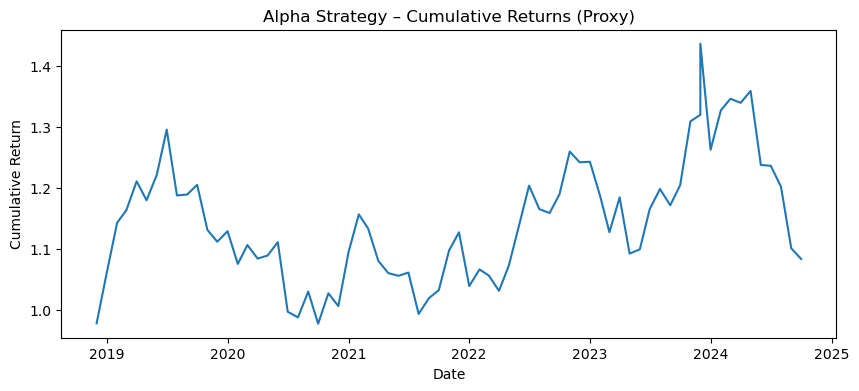

In [19]:
plt.figure(figsize=(10,4))
plt.plot(strategy["date"], strategy["cum_return"])
plt.title("Alpha Strategy – Cumulative Returns (Proxy)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.show()


In [21]:
features = ["auto_sales_yoy", "real_rate"]
model_df = data.dropna(subset=features + ["proxy_return"])

X = model_df[features]
y = model_df["proxy_return"]

tscv = TimeSeriesSplit(5)

preds, actuals = [], []

for train_idx, test_idx in tscv.split(X):
    model = Ridge(alpha=1.0)
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds.extend(model.predict(X.iloc[test_idx]))
    actuals.extend(y.iloc[test_idx])

r2 = r2_score(actuals, preds)
rmse = mean_squared_error(actuals, preds, squared=False)

r2, rmse


(-0.05250758701932701, 0.04843159754045071)

In [23]:
print("Rows in data:", len(data))
print("Rows in strategy:", len(strategy))
print("Alpha NaNs:", data["alpha_signal"].isna().sum())


Rows in data: 84
Rows in strategy: 72
Alpha NaNs: 12


In [25]:
# Market proxy (broad index-like behavior)
np.random.seed(123)

data["market_proxy_return"] = np.random.normal(
    loc=0.008,    # slightly lower than stock return
    scale=0.04,
    size=len(data)
)

In [27]:
strategy_sn = data.dropna(subset=["alpha_signal"]).copy()

strategy_sn["position"] = np.sign(strategy_sn["alpha_signal"])

# Sector-neutral return
strategy_sn["strategy_return_sn"] = (
    strategy_sn["position"] *
    (strategy_sn["proxy_return"] - strategy_sn["market_proxy_return"])
)

strategy_sn["cum_return_sn"] = (1 + strategy_sn["strategy_return_sn"]).cumprod()

strategy_sn[["date", "cum_return_sn"]].tail()

,date,cum_return_sn
79,2024-06-01,1.1157
80,2024-07-01,1.0496
81,2024-08-01,0.9999
82,2024-09-01,0.9904
83,2024-10-01,0.9347


In [29]:
metrics_sector_neutral = {
    "Periods": len(strategy_sn),
    "Annual Return": strategy_sn["cum_return_sn"].iloc[-1] ** (12 / len(strategy_sn)) - 1,
    "Sharpe Ratio": np.sqrt(12) * strategy_sn["strategy_return_sn"].mean() /
                    strategy_sn["strategy_return_sn"].std(),
    "Max Drawdown": (strategy_sn["cum_return_sn"] /
                     strategy_sn["cum_return_sn"].cummax() - 1).min()
}

metrics_sector_neutral

{'Periods': 72,
 'Annual Return': -0.011183513511042853,
 'Sharpe Ratio': 0.06977379597320861,
 'Max Drawdown': -0.5193044648698476}

In [31]:
for lag in [1, 2, 3]:
    data[f"auto_sales_yoy_lag{lag}"] = data["auto_sales_yoy"].shift(lag)
    data[f"real_rate_lag{lag}"] = data["real_rate"].shift(lag)

In [33]:
lag_features = [
    "auto_sales_yoy_lag1", "auto_sales_yoy_lag2", "auto_sales_yoy_lag3",
    "real_rate_lag1", "real_rate_lag2", "real_rate_lag3"
]

lag_df = data.dropna(subset=lag_features + ["proxy_return"])

X_lag = lag_df[lag_features]
y_lag = lag_df["proxy_return"]

tscv = TimeSeriesSplit(5)

preds_lag, actuals_lag = [], []

for tr, te in tscv.split(X_lag):
    model = Ridge(alpha=1.0)
    model.fit(X_lag.iloc[tr], y_lag.iloc[tr])
    preds_lag.extend(model.predict(X_lag.iloc[te]))
    actuals_lag.extend(y_lag.iloc[te])

r2_lag = r2_score(actuals_lag, preds_lag)
rmse_lag = mean_squared_error(actuals_lag, preds_lag, squared=False)

r2_lag, rmse_lag

(-0.10473650047171001, 0.0509009919272377)

In [35]:
signal_stability = data.dropna(subset=["alpha_signal"]).copy()

signal_stability["rolling_mean"] = (
    signal_stability["alpha_signal"].rolling(12).mean()
)

signal_stability["rolling_std"] = (
    signal_stability["alpha_signal"].rolling(12).std()
)

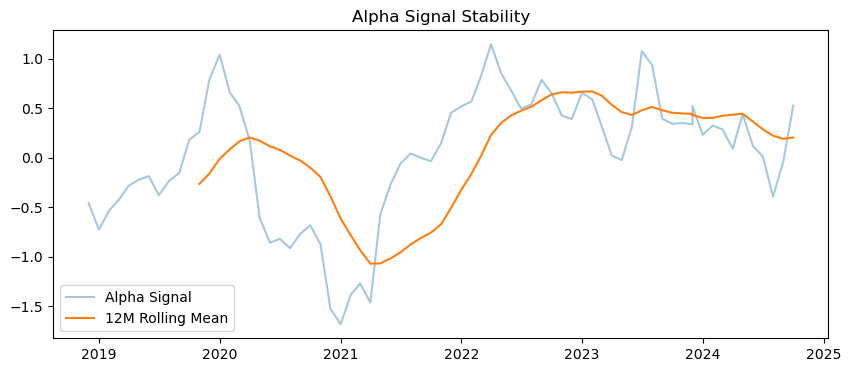

In [37]:
plt.figure(figsize=(10,4))
plt.plot(signal_stability["date"], signal_stability["alpha_signal"],
         alpha=0.4, label="Alpha Signal")
plt.plot(signal_stability["date"], signal_stability["rolling_mean"],
         label="12M Rolling Mean")
plt.title("Alpha Signal Stability")
plt.legend()
plt.show()

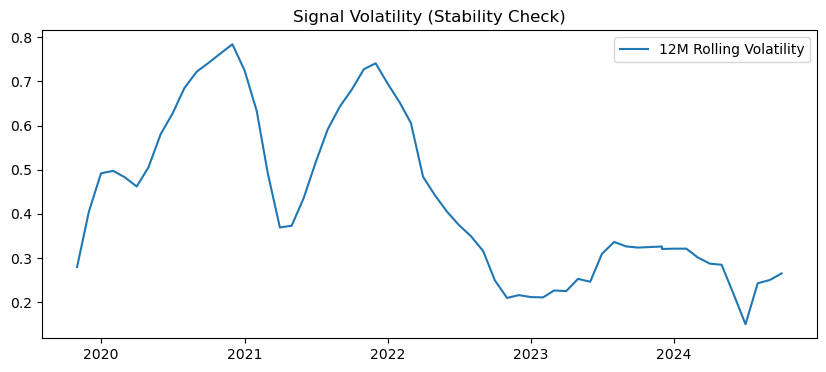

In [39]:
plt.figure(figsize=(10,4))
plt.plot(signal_stability["date"], signal_stability["rolling_std"],
         label="12M Rolling Volatility")
plt.title("Signal Volatility (Stability Check)")
plt.legend()
plt.show()

In [41]:
results = {
    "baseline_metrics": metrics,
    "sector_neutral_metrics": metrics_sector_neutral,
    "lagged_model_r2": r2_lag,
    "lagged_model_rmse": rmse_lag
}

results

{'baseline_metrics': {'Periods': 72,
  'Annual Return': 0.013418200440696415,
  'Sharpe Ratio': 0.16310867178048574,
  'Max Drawdown': -0.24563680276788946,
  'Average Turnover': 0.2535211267605634},
 'sector_neutral_metrics': {'Periods': 72,
  'Annual Return': -0.011183513511042853,
  'Sharpe Ratio': 0.06977379597320861,
  'Max Drawdown': -0.5193044648698476},
 'lagged_model_r2': -0.10473650047171001,
 'lagged_model_rmse': 0.0509009919272377}

In [43]:
# Save metrics
pd.DataFrame(results).to_csv("results_summary.csv")

# Save strategy time series
strategy.to_csv("strategy_baseline.csv", index=False)
strategy_sn.to_csv("strategy_sector_neutral.csv", index=False)

# Save signal data
signal_stability.to_csv("signal_stability.csv", index=False)